# Binary Classification Deep Learning Model for Breast Cancer Wisconsin (Original) Using Keras
### David Lowe
### November 4, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Breast Cancer Wisconsin dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: The dataset contains various measurements of breast tissue samples for cancer diagnosis. It contains measurements such as the thickness of the clump, the uniformity of cell size and shape, the marginal adhesion, and so on. Dr. William H. Wolberg of the University of Wisconsin Hospitals in Madison is the original provider of this dataset.

ANALYSIS: The baseline performance of the model achieved an average accuracy score of 97.13%. Using the same training parameters, the model processed the test dataset with an accuracy of 97.71%, which was consistent with the result from the training data.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities

Dataset Used: Breast Cancer Wisconsin (Original) Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29

Any deep-learning modeling project genrally can be broken down into about six major tasks:
0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Create the random seed numbers for reproducible results
seedNum = 88

In [2]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.set_random_seed(seedNum)
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
# Configure a new global `tensorflow` session
import keras as K
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.backend.set_session(sess)

Using TensorFlow backend.


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_kernel_init = K.initializers.RandomNormal(seed=seedNum)
default_loss = 'binary_crossentropy'
default_optimizer = 'adam'
default_epochs = 100
default_batches = 5
default_metrics = ['accuracy']

# Set the number of folds for cross validation
folds = 10

In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.a) Load dataset

In [8]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = dest_file
attrNames = ['attr' + str(i).zfill(2) for i in range(1,10)]
colNames = ['id'] + attrNames + ['target']
Xy_original = pd.read_csv(inputFile, names=colNames, sep=',', header=None, index_col=False, na_values=['?'])

# Take a peek at the dataframe after the import
Xy_original.head(10)

,id,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,target
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4
6,1018099,1,1,1,1,2,10.0,3,1,1,2
7,1018561,2,1,2,1,2,1.0,3,1,1,2
8,1033078,2,1,1,1,2,1.0,1,1,5,2
9,1033078,4,2,1,1,2,1.0,2,1,1,2


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id        699 non-null int64
attr01    699 non-null int64
attr02    699 non-null int64
attr03    699 non-null int64
attr04    699 non-null int64
attr05    699 non-null int64
attr06    683 non-null float64
attr07    699 non-null int64
attr08    699 non-null int64
attr09    699 non-null int64
target    699 non-null int64
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


In [10]:
Xy_original.describe()

,id,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,target
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [11]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

id         0
attr01     0
attr02     0
attr03     0
attr04     0
attr05     0
attr06    16
attr07     0
attr08     0
attr09     0
target     0
dtype: int64
Total number of NaN in the dataframe:  16


### 1.b) Data Cleaning

In [12]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping non-essential features
Xy_original.drop(columns=['id'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
Xy_original['attr06'].fillna(value=Xy_original['attr06'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Convert features with 2/4 (benign/malignant) levels into categorical feature of 0/1
def reClassSomecol(target):
    if (target == 4): return 1
    else: return 0
Xy_original['targetVar'] = Xy_original['target'].apply(reClassSomecol)
Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,targetVar
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0
5,8,10,10,8,7,10.0,9,7,1,1
6,1,1,1,1,2,10.0,3,1,1,0
7,2,1,2,1,2,1.0,3,1,1,0
8,2,1,1,1,2,1.0,1,1,5,0
9,4,2,1,1,2,1.0,2,1,1,0


In [13]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
attr01       699 non-null int64
attr02       699 non-null int64
attr03       699 non-null int64
attr04       699 non-null int64
attr05       699 non-null int64
attr06       699 non-null float64
attr07       699 non-null int64
attr08       699 non-null int64
attr09       699 non-null int64
targetVar    699 non-null int64
dtypes: float64(1), int64(9)
memory usage: 54.7 KB


In [14]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,targetVar
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.486409,3.437768,2.866953,1.589413,0.344778
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.621929,2.438364,3.053634,1.715078,0.475636
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [15]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

attr01       0
attr02       0
attr03       0
attr04       0
attr05       0
attr06       0
attr07       0
attr08       0
attr09       0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.c) Splitting Data into Training and Test Sets

In [16]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [17]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (699, 10) X_original.shape: (699, 9) y_original.shape: (699,)


In [18]:
# Apply feature scaling techniques

X_colNames = list(X_original.columns)
X_original[X_colNames] = preprocessing.scale(X_original[X_colNames])

In [19]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

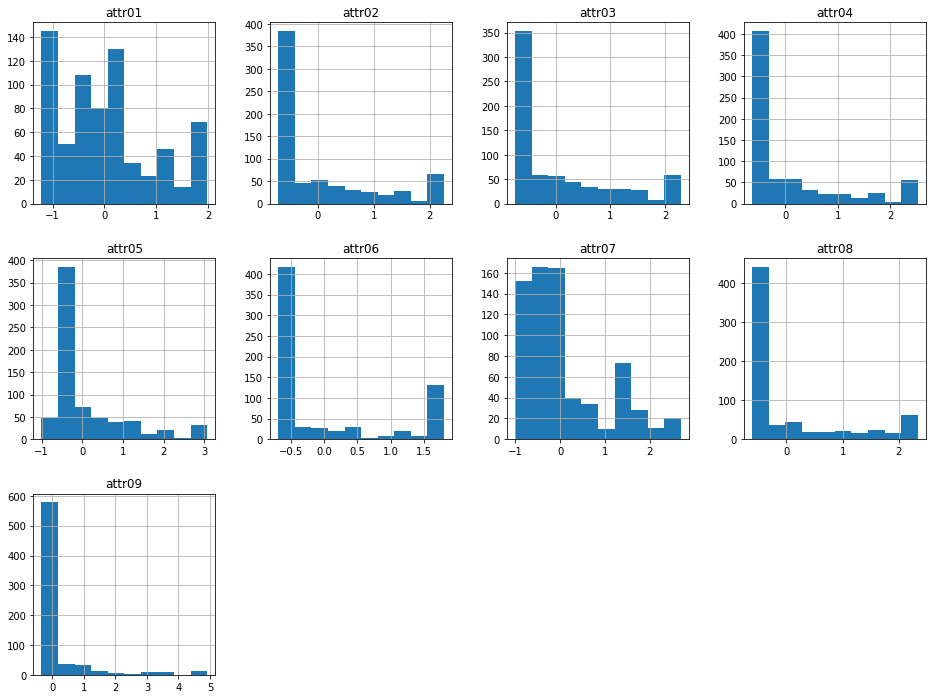

In [20]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [21]:
# Encode class values as integers and perform one-hot-encoding
encoder = preprocessing.LabelEncoder()
encoder.fit(y_original)
y_encoded = encoder.transform(y_original)
print(y_encoded)

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1
 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0
 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1
 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0
 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1
 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 1 0 0 0 1 1 1 0 1 0 

In [22]:
# Finalize the training and testing datasets for the modeling activities
X_encoded = X_original.to_numpy()

if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.shape: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.shape: {}".format(y_test.shape, type(y_test)))

X_train.shape: (524, 9) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (524,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (175, 9) X_test.shape: <class 'numpy.ndarray'>
y_test.shape: (175,) y_test.shape: <class 'numpy.ndarray'>


In [23]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [24]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [25]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = K.models.Sequential()
    default_model.add(Dense(9, input_dim=9, kernel_initializer=default_kernel_init, activation='relu'))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init, activation='sigmoid'))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [26]:
# Initialize the Keras model
cv_model = KerasClassifier(build_fn=create_default_model, epochs=default_epochs, batch_size=default_batches, verbose=0)

In [27]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [28]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [29]:
# Fit and evaluate the Keras model using 10-fold cross validation
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_metrics)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Generating results using the metrics of ['accuracy']
All cross-Validate results: [0.92452831 0.98113208 0.90566038 1.         0.98076923 0.98076923
 0.96153846 0.9423077  0.98076923 0.96153846]
Baseline results [mean (std)]: 96.19% (2.80%)


In [30]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [31]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [32]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = K.models.Sequential()
    customized_model.add(Dense(9, input_dim=9, kernel_initializer=kernel_init, activation='relu'))
    customized_model.add(Dense(1, kernel_initializer=kernel_init, activation='sigmoid'))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [33]:
# Create model
grid_model = KerasClassifier(build_fn=create_customized_model, verbose=0)

# Perform grid search using different epochs, batch sizes, and optimizers
optimizer_grid = ['adam', 'rmsprop']
init_grid = ['RandomNormal', 'glorot_normal', 'Orthogonal']
epoch_grid = [100, 150, 200]
batch_grid = [10, 15, 20]
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.971374 using {'batch_size': 15, 'epochs': 100, 'kernel_init': 'glorot_normal', 'optimizer': 'rmsprop'}
0.965649 (0.016685) with: {'batch_size': 10, 'epochs': 100, 'kernel_init': 'RandomNormal', 'optimizer': 'adam'}
0.963740 (0.016458) with: {'batch_size': 10, 'epochs': 100, 'kernel_init': 'RandomNormal', 'optimizer': 'rmsprop'}
0.961832 (0.008619) with: {'batch_size': 10, 'epochs': 100, 'kernel_init': 'glorot_normal', 'optimizer': 'adam'}
0.967557 (0.019690) with: {'batch_size': 10, 'epochs': 100, 'kernel_init': 'glorot_normal', 'optimizer': 'rmsprop'}
0.965649 (0.012952) with: {'batch_size': 10, 'epochs': 100, 'kernel_init': 'Orthogonal', 'optimizer': 'adam'}
0.963740 (0.015314) with: {'batch_size': 10, 'epochs': 100, 'kernel_init': 'Orthogonal', 'optimizer': 'rmsprop'}
0.963740 (0.014021) with: {'batch_size': 10, 'epochs': 150, 'kernel_init': 'RandomNormal', 'optimizer': 'adam'}
0.959924 (0.019477) with: {'batch_size': 10, 'epochs': 150, 'kernel_init': 'RandomNormal', 'optimi

In [34]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [35]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [36]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=1)

Forming the final model using: optimizer=rmsprop, kernel=glorot_normal, epochs=100, batch_size=15
Epoch 1/100
524/524 [==============================] - 27s 52ms/step - loss: 0.5126 - acc: 0.9198
Epoch 2/100
524/524 [==============================] - 1s 1ms/step - loss: 0.4105 - acc: 0.9504
Epoch 3/100
524/524 [==============================] - 1s 1ms/step - loss: 0.3274 - acc: 0.9561
Epoch 4/100
524/524 [==============================] - 1s 1ms/step - loss: 0.2595 - acc: 0.9637
Epoch 5/100
524/524 [==============================] - 0s 898us/step - loss: 0.2087 - acc: 0.9676
Epoch 6/100
524/524 [==============================] - 0s 910us/step - loss: 0.1707 - acc: 0.9676
Epoch 7/100
524/524 [==============================] - 0s 936us/step - loss: 0.1437 - acc: 0.9656
Epoch 8/100
524/524 [==============================] - 0s 920us/step - loss: 0.1246 - acc: 0.9676
Epoch 9/100
524/524 [==============================] - 0s 923us/step - loss: 0.1113 - acc: 0.9656
Epoch 10/100
524/524 [====

In [38]:
# Display a summary of the final model
print(final_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_563 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_564 (Dense)            (None, 1)                 10        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f%%" % (final_model.metrics_names[0], scores[0]*100))

175/175 [==============================] - 12s 69ms/step

acc: 97.71%

loss: 6.45%


In [40]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_original)

# Summarize the first 20 cases
for i in range(20):
	print('%s => %d (expected %d)' % (X_test[i].tolist(), predictions[i], y_test[i]))

[-0.5038655932410934, -0.6999950505092654, -0.7432990353709374, -0.6332471645125597, -0.5495613588663254, 0.41819560385677423, 0.6411472095809492, -0.6118250369454719, -0.3439117826575238] => 0 (expected 0)
[-0.1484649376653878, -0.6999950505092654, -0.7432990353709374, 0.06768675155122376, -1.001494758686986, -0.6869791677722814, -0.590066800026423, -0.6118250369454719, -0.3439117826575238] => 1 (expected 0)
[0.20693571791031778, -0.6999950505092654, 0.2668747022653916, -0.6332471645125597, -0.5495613588663254, -0.6869791677722814, -0.17966213015729893, -0.28411185623674784, -0.3439117826575238] => 0 (expected 0)
[-0.1484649376653878, -0.6999950505092654, -0.7432990353709374, -0.6332471645125597, -0.5495613588663254, -0.6869791677722814, -0.17966213015729893, 1.026740866598148, -0.3439117826575238] => 1 (expected 0)
[0.9177370290617288, 1.595632149317702, 1.2770484399017208, 1.119087625646899, 0.35430544077499576, -0.13439178195775361, 1.8723612191883217, 1.682167228015596, 1.40653241

In [41]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [42]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 3:55:40.825066
